In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

First, we define multiple possible weighting functions (the weight that the combined system places on the human).. Each of them takes as inputs $a$, the algorithm's loss and $h$, the unaided human's loss. Based on these values (as well as potentially other parameters) it returns a weight between 0 and 1. 

In [2]:
def min_w(a, h):
    '''
    Weight of 1 on unaided human whenever they have LOWER loss (combining function becomes minimum function).  
    '''
    return (h < a)*1.0

def max_w(a, h):
    '''
    Weight of 1 on unaided human whenever they have HIGHER loss (combining function becomes maximum function).  
    '''
    return (h > a)*1.0

def exemplar_calc(a, h, m, b):
    '''
    Novel model to this work. Gives a weight that scales linearly with the gap between loss of algorithm and
    and unaided human (a-h) with additive constant b and multiplicative constant m. 
    
    '''
    return (b+m*(a-h)).clip(lower = 0, upper =1)

def bansal_calc(a, h, ps, epsilon):
    '''
    Approximate version of model in Bansal et al. Gives a weight of 1-p_s on the human whenever the algorithm
    has loss epsilon lower than the unaided human (otherwise, weight p_s on the human). 
    
    '''
    return (pd.DataFrame([1-ps] *len(a)).where(a<=h - epsilon).fillna(0) + 
            pd.DataFrame([ps] * len(a)).where(a>h- epsilon).fillna(0))

def vodrahalli_calc(a, h, epsilon, m, b):
    '''
    Approximate version of model in Vodrahalli et al. Gives a weight of 1 on the human whenever the algorithm
    has loss epsilon higher than the unaided human. Otherwise, give a weight that scales linearly with the 
    difference in losses a-h (here, using exemplar function). 
    
    '''
    return exemplar_calc(a, h, m, b).where(a<= h-epsilon).fillna(1)

In [3]:
def comb_calc(p =0.5, A = 0.5, H = 1, weight_func = exemplar_calc, kwargs={'b': 0.5, 'm': 0.5}, 
                  dh = None, da = None, weight_vals = [0.5, 0.6], n_points = 50):
    '''
    Calculate combined error for N=2 regimes. 
    

    Args:
        p: frequency of 1st instance type
        A: average error for algorithm
        H: average error for human
        weight_func: if not None, the weight function
        kwargs: arguments for weight function
        dh: if not None, the variability for human (instance type 0 error is H + dh, type 1 is H - dh). 
            if None, creates a dataframe of dh values. 
        da: if not None, the variability for algorithm (instance type 0 error is A + da, type 1 is A - da). 
            if None, creates a dataframe of da values. 
        weight_vals: if weight is None, the manual weight for human in regime 1, regime 2 (length 2 list)
        n_points: number of points to explore, if dh, da are None
    Returns:
        dataframe with errors (for each of unaided human, algorithm, combined error) for each dh, da value.  
    '''
    
    df = pd.DataFrame()
    
    if (dh == None) & (da == None):
        # Explore all plausible dh, da values (that don't lead to negative losses)
        dh_col = pd.DataFrame(np.linspace(-H, H *(1-p)/p, n_points))[0]
        da_col = pd.DataFrame(np.linspace(-A, A*(1-p)/p, n_points))[0]
        # Look at all combinations of da, dh values
        productframe = pd.DataFrame(list(product(dh_col, da_col)))
        df['dh'] = productframe[0]
        df['da'] = productframe[1]
    elif (dh == None) | (da == None): 
        print('Error: dh and da must match')
    else: 
        # Use provided dh, da values
        df['dh'] = pd.DataFrame(dh)[0]
        df['da'] = pd.DataFrame(da)[0]
        
    # calculate losses for algorithm, unaided human
    df['a1'] = A + df['da']
    df['a2'] = A - df['da']*p/(1-p)
    
    df['h1'] = H + df['dh']
    df['h2'] = H - df['dh']*p/(1-p)
    
    if weight_func == None:
        # use user-provided weights
        df['w1'] = weight_vals[0]
        df['w2'] = weight_vals[1]
    else:
        # calculate weights
        df['w1'] = weight_func(df['a1'], df['h1'], **kwargs)
        df['w2'] = weight_func(df['a2'], df['h2'], **kwargs)
    
    # calculate combined loss
    df['c1']  = df['w1']*df['h1'] + (1-df['w1'])*df['a1']
    df['c2']  = df['w2']*df['h2'] + (1-df['w2'])*df['a2']
    df['loss'] = df['c1']*p + df['c2']*(1-p)
    
    df['diffdelta'] = np.abs(df['da'] - df['dh']) # sum of delta terms (measures variability)
    df['diff1'] = df['h1'] - df['a1'] # gap between unaided human and algorithm in regime 1
    
    return df.sort_values(by = 'diffdelta')

Code for motivating example (Tables 1-4) and Tables 5-7.  

In [4]:
# Scenario 1
comb_calc(A = 0.5, H = 0.75, weight_func = None, dh = [0.25], da = [-0.15], weight_vals = [0.9, 0.1]) 

,dh,da,a1,a2,h1,h2,w1,w2,c1,c2,loss,diffdelta,diff1
0,0.25,-0.15,0.35,0.65,1.0,0.5,0.9,0.1,0.935,0.635,0.785,0.4,0.65


In [5]:
# Scenario 2
comb_calc(A = 0.5, H = 0.75, weight_func = None, dh = [0.25], da = [-0.15], weight_vals = [0.25, 0.75]) 

,dh,da,a1,a2,h1,h2,w1,w2,c1,c2,loss,diffdelta,diff1
0,0.25,-0.15,0.35,0.65,1.0,0.5,0.25,0.75,0.5125,0.5375,0.525,0.4,0.65


In [6]:
# Scenario 3 & Table 5 (anti-correlated error)
comb_calc(A = 0.5, H = 0.75, weight_func = None, dh = [0.4], da = [-0.3], weight_vals = [0.25, 0.75]) 

,dh,da,a1,a2,h1,h2,w1,w2,c1,c2,loss,diffdelta,diff1
0,0.4,-0.3,0.2,0.8,1.15,0.35,0.25,0.75,0.4375,0.4625,0.45,0.7,0.95


In [7]:
# Table 6 (correlated error)
comb_calc(A = 0.5, H = 0.75, weight_func = None, dh = [0.73], da = [0.03], weight_vals = [0.25, 0.75]) 

,dh,da,a1,a2,h1,h2,w1,w2,c1,c2,loss,diffdelta,diff1
0,0.73,0.03,0.53,0.47,1.48,0.02,0.25,0.75,0.7675,0.1325,0.45,0.7,0.95


In [8]:
# Table 7 (loss disparity increased in combined system)
a_loss = pd.DataFrame([0.85, 0.02, 0.45]).T # loss of algorithm in each of N=3 regimes
h_loss = pd.DataFrame([0.95, 0.95, 0.15]).T # loss of unaided human
weight_vals = exemplar_calc(a_loss, h_loss, m = 0.5, b = 0.5) # weights calculated with exemplar function
c_loss = weight_vals * h_loss + (1-weight_vals)*a_loss # combined loss
c_loss

,0,1,2
0,0.895,0.05255,0.255


Code to create Figure 1 (plots the combed loss, according to multiple combining functions). 

In [9]:
# calculate combined loss
bansal = comb_calc(weight_func = bansal_calc, kwargs = {'ps': 0.9, 'epsilon': 0.1})
vodrahalli = comb_calc(weight_func = vodrahalli_calc, kwargs = {'b': 0.5, 'm': 0.6, 'epsilon': 0.05})
min_val = comb_calc(weight_func = min_w, kwargs = {})
exemplar = comb_calc(kwargs = {'b': 0.5, 'm': 0.6})

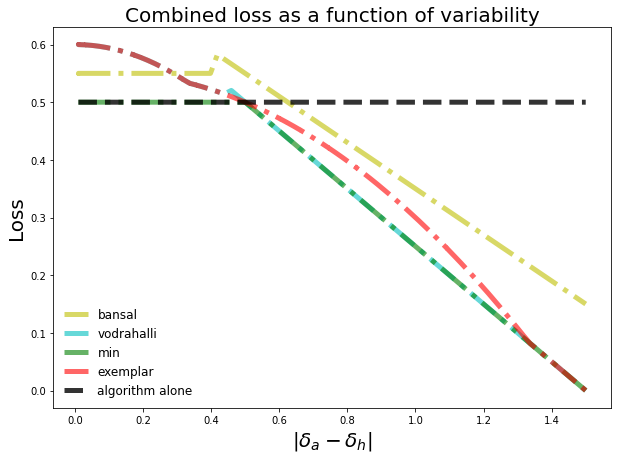

In [10]:
fig, ax = plt.subplots(1, 1)
fig = plt.gcf()
fig.set_size_inches(10, 7)

algerr = [0.5] * len(bansal['da']) # average loss of algorithm is 0.5


ax.plot(bansal['diffdelta'], bansal['loss'], 'y-.', lw=5, alpha=0.6, label='bansal')
ax.plot(vodrahalli['diffdelta'], vodrahalli['loss'],'c-.',  lw=5, alpha=0.6, label='vodrahalli')
ax.plot(min_val['diffdelta'], min_val['loss'],'g-.',  lw=5, alpha=0.6, label='min')
ax.plot(exemplar['diffdelta'], exemplar['loss'], 'r-.', lw=5, alpha=0.6, label='exemplar')
ax.plot(exemplar['diffdelta'], algerr, 'k--', lw=5, alpha=0.8, label='algorithm alone')
ax.set_xlabel(r'$\vert\delta_a - \delta_h\vert$', fontsize = 20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_title('Combined loss as a function of variability', fontsize = 20)
ax.legend(loc='best', frameon=False, fontsize = 12)

plt.show()

Code to create Figure 3 (plots the weight placed on the unaided human for various combining functions). 

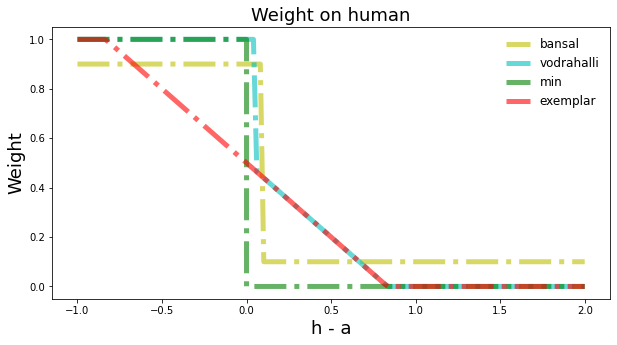

In [11]:
# sort combined error by gap
bansal_d1 = bansal.sort_values(by = 'diff1')
vodrahalli_d1 = vodrahalli.sort_values(by = 'diff1')
min_val_d1 = min_val.sort_values(by = 'diff1')
exemplar_d1 = exemplar.sort_values(by = 'diff1')

# plot weight each weighting function places on unaided human
fig, ax = plt.subplots(1, 1) # 
fig = plt.gcf()
fig.set_size_inches(10, 5)

ax.plot(bansal_d1['diff1'], bansal_d1['w1'], 'y-.', lw=5, alpha=0.6, label='bansal')
ax.plot(vodrahalli_d1['diff1'], vodrahalli_d1['w1'], 'c-.', lw=5, alpha=0.6, label='vodrahalli')
ax.plot(min_val_d1['diff1'], min_val_d1['w1'],'g-.', lw=5, alpha=0.6, label='min')
ax.plot(exemplar_d1['diff1'], exemplar_d1['w1'], 'r-.', lw=5, alpha=0.6, label='exemplar')
ax.set_xlabel('h - a', fontsize = 18)
ax.set_ylabel('Weight', fontsize =18)
ax.set_title('Weight on human', fontsize = 18)
ax.legend(loc='best', frameon=False, fontsize = 12)

plt.show()